In [52]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# load inflow dataset into dataframe
inflow_data = pd.read_excel("InflowData_1.xlsx")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

In [54]:
# load weather data into dataframe
weather_data = pd.read_excel("WeatherData_1.xlsx")

# print first two rows
weather_data.head(2)

Date-time CET-CEST (DD/MM/YYYY HH:mm)  Rainfall depth (mm)  \
0                      01/01/2021 00:00                  0.0   
1                      01/01/2021 01:00                  0.0   

   Air temperature (°C)  Air humidity (%)  Windspeed (km/h)  
0                   7.2              79.0               9.0  
1                   7.3              79.0               6.0

In [55]:
# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# print first two rows
inflow_data.head(3)

DMA A (L/s)  DMA B (L/s)  DMA C (L/s)  \
Date-time CET-CEST (DD/MM/YYYY HH:mm)                                          
2021-01-01 00:00:00                            NaN          NaN       3.7000   
2021-01-01 01:00:00                            NaN          NaN       3.5625   
2021-01-01 02:00:00                            NaN          NaN       3.2725   

                                       DMA D (L/s)  DMA E (L/s)  DMA F (L/s)  \
Date-time CET-CEST (DD/MM/YYYY HH:mm)                                          
2021-01-01 00:00:00                            NaN          NaN          NaN   
2021-01-01 01:00:00                            NaN          NaN          NaN   
2021-01-01 02:00:00                            NaN          NaN          NaN   

                                       DMA G (L/s)  DMA H (L/s)  DMA I (L/s)  \
Date-time CET-CEST (DD/MM/YYYY HH:mm)                                          
2021-01-01 00:00:00                            NaN          NaN          NaN   
2021-01-01 01:00:00                            NaN          NaN          NaN   
2021-01-01 02:00:00                            NaN          NaN          NaN   

                                       DMA J (L/s)  
Date-time CET-CEST (DD/MM/YYYY HH:mm)               
2021-01-01 00:00:00                            NaN  
2021-01-01 01:00:00                            NaN  
2021-01-01 02:00:00                            NaN

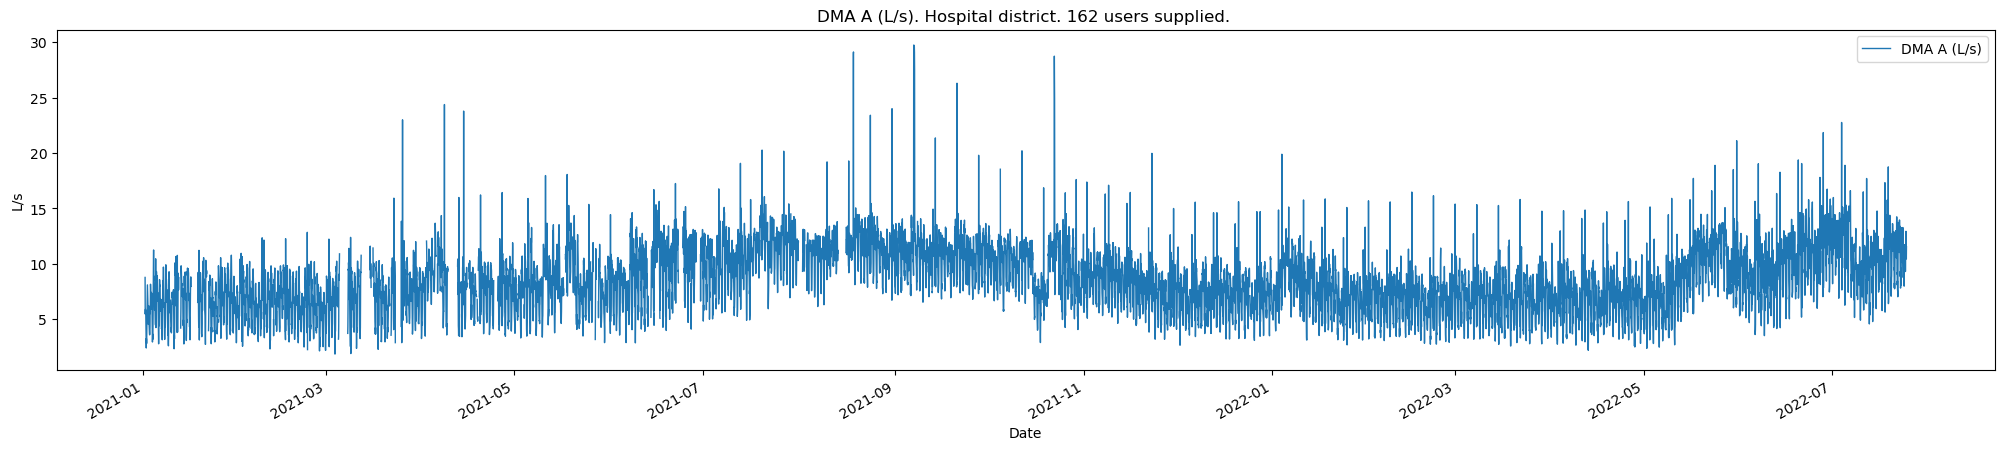

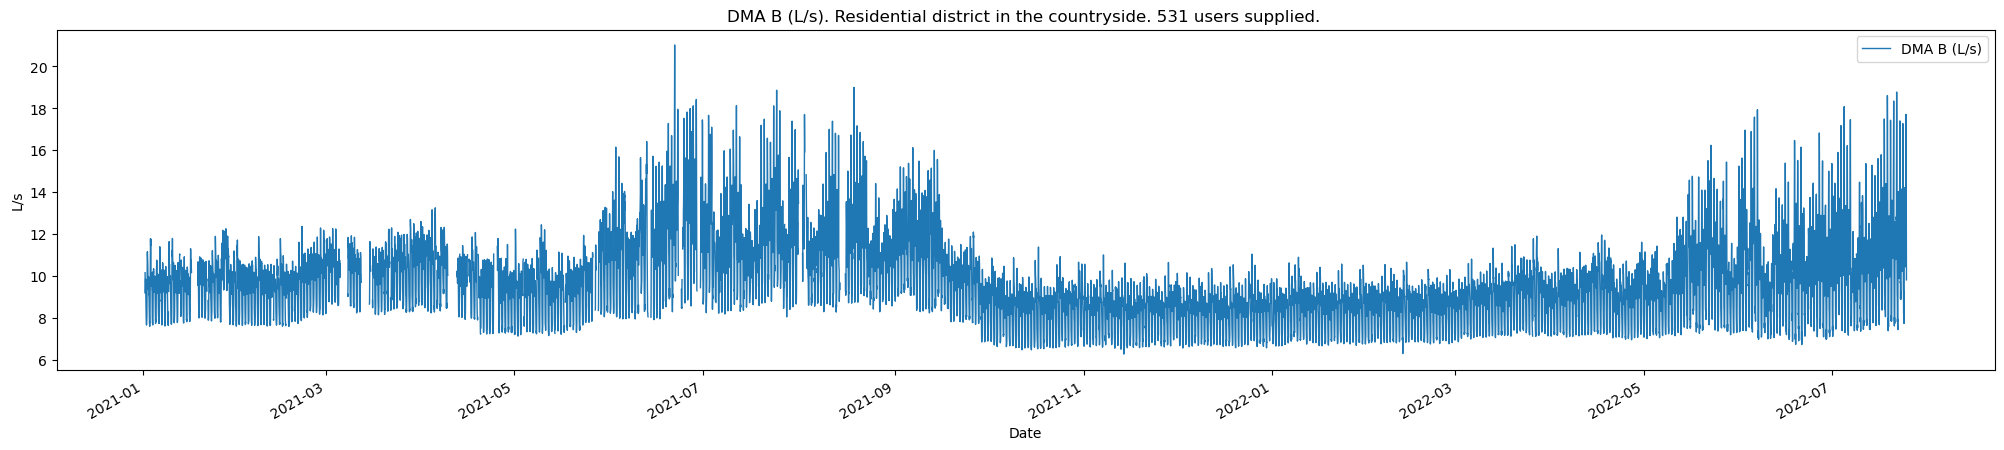

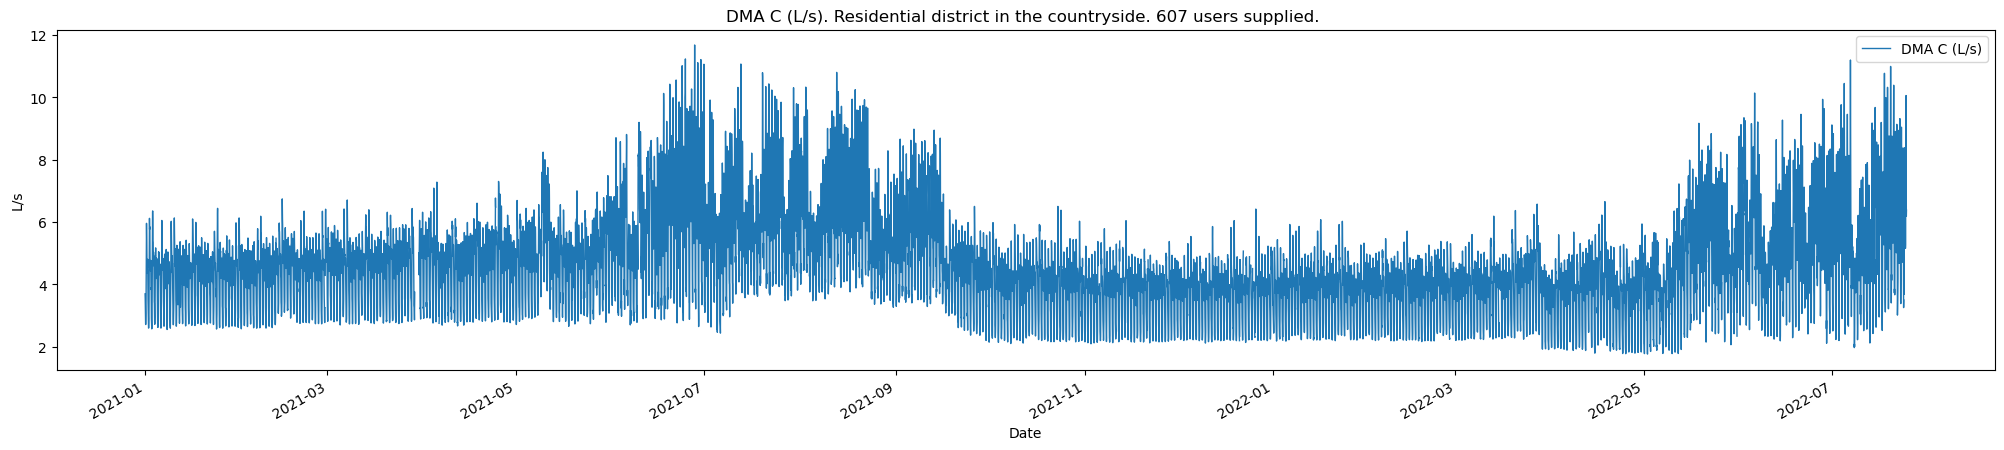

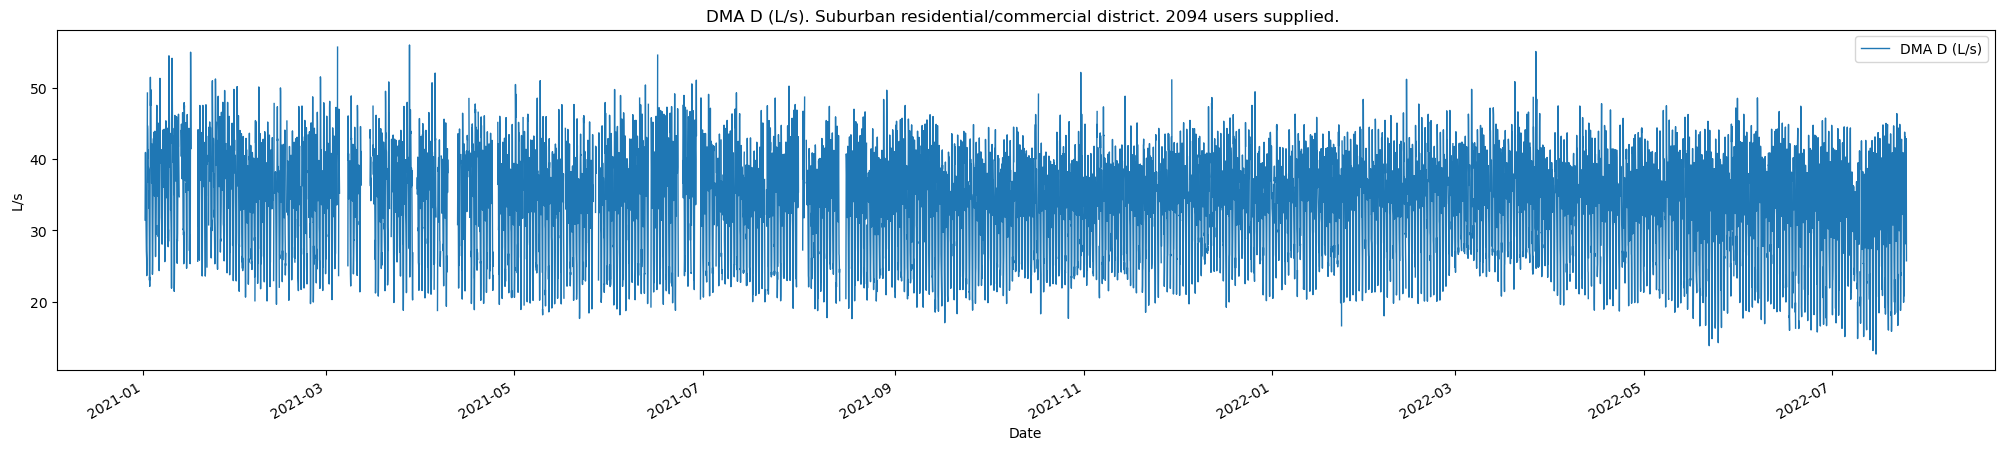

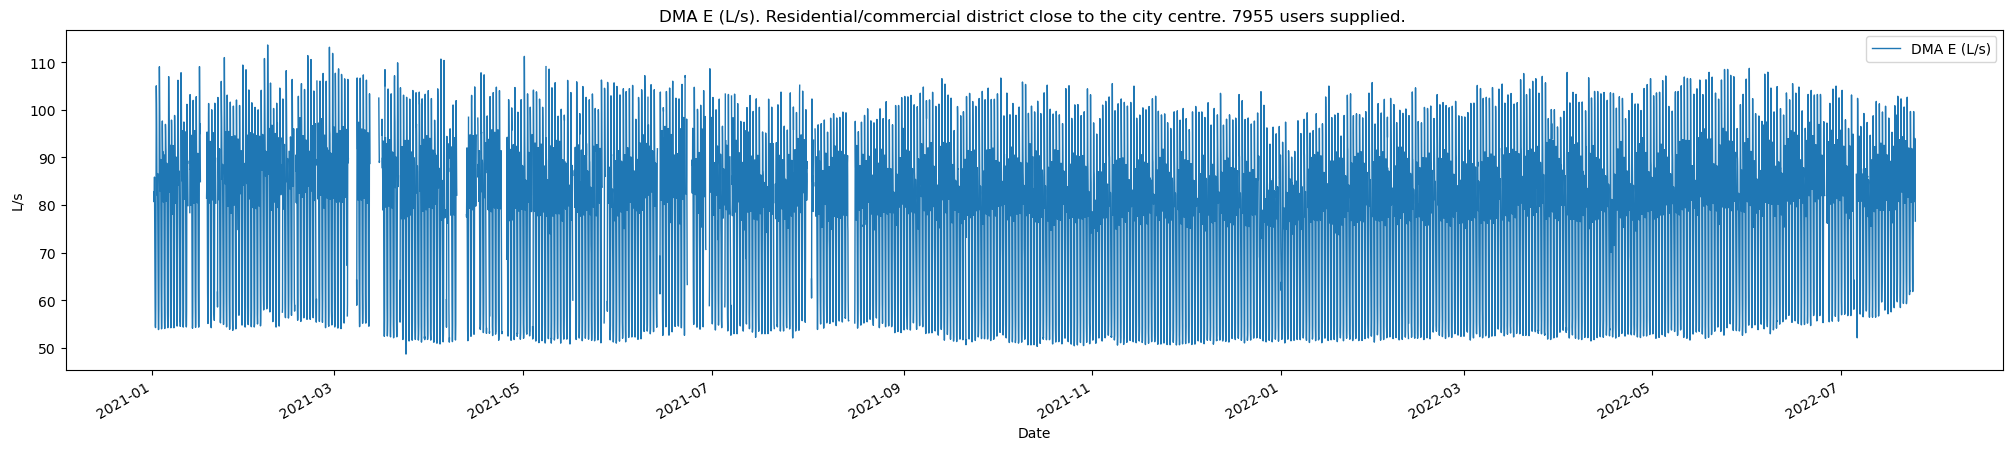

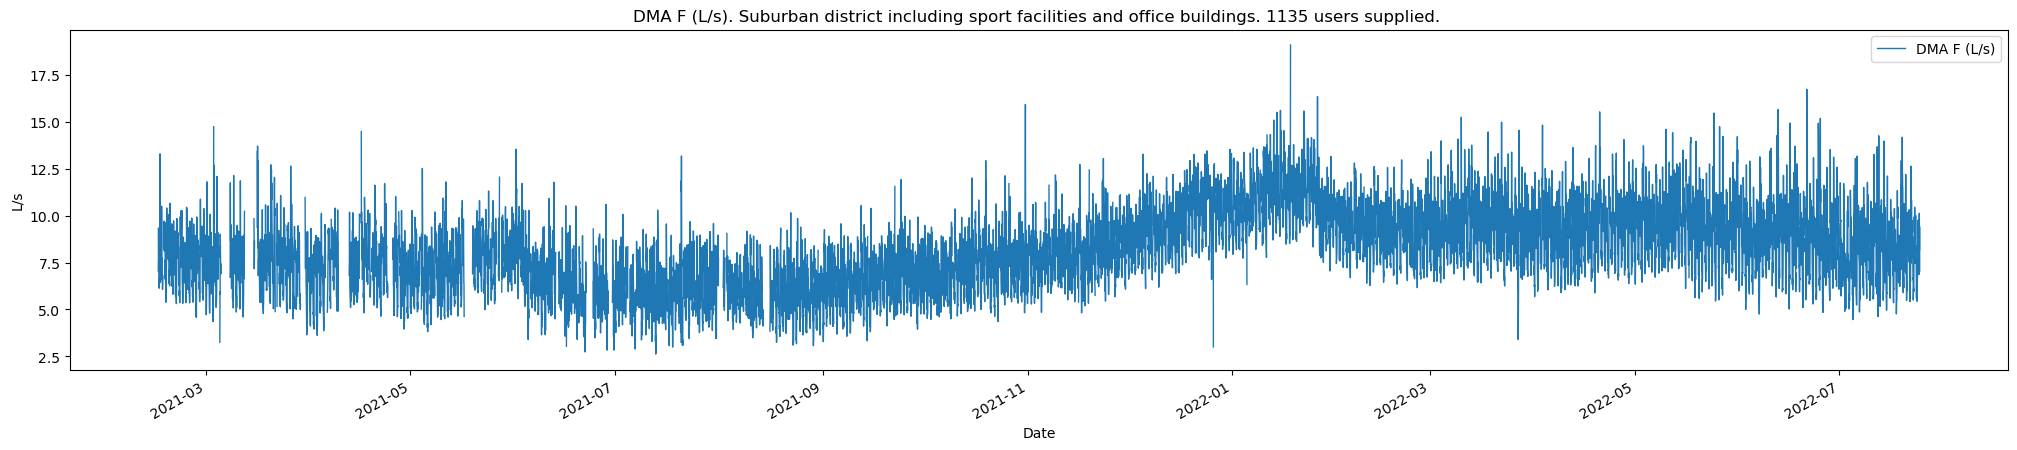

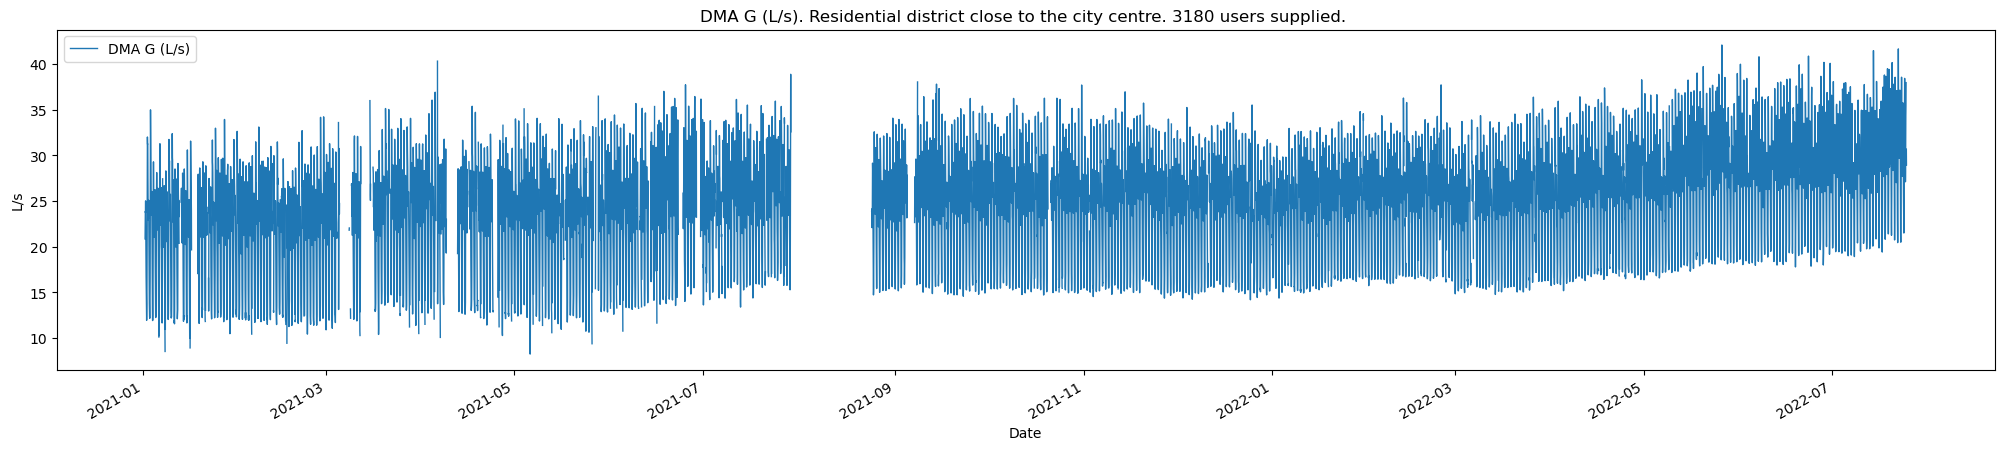

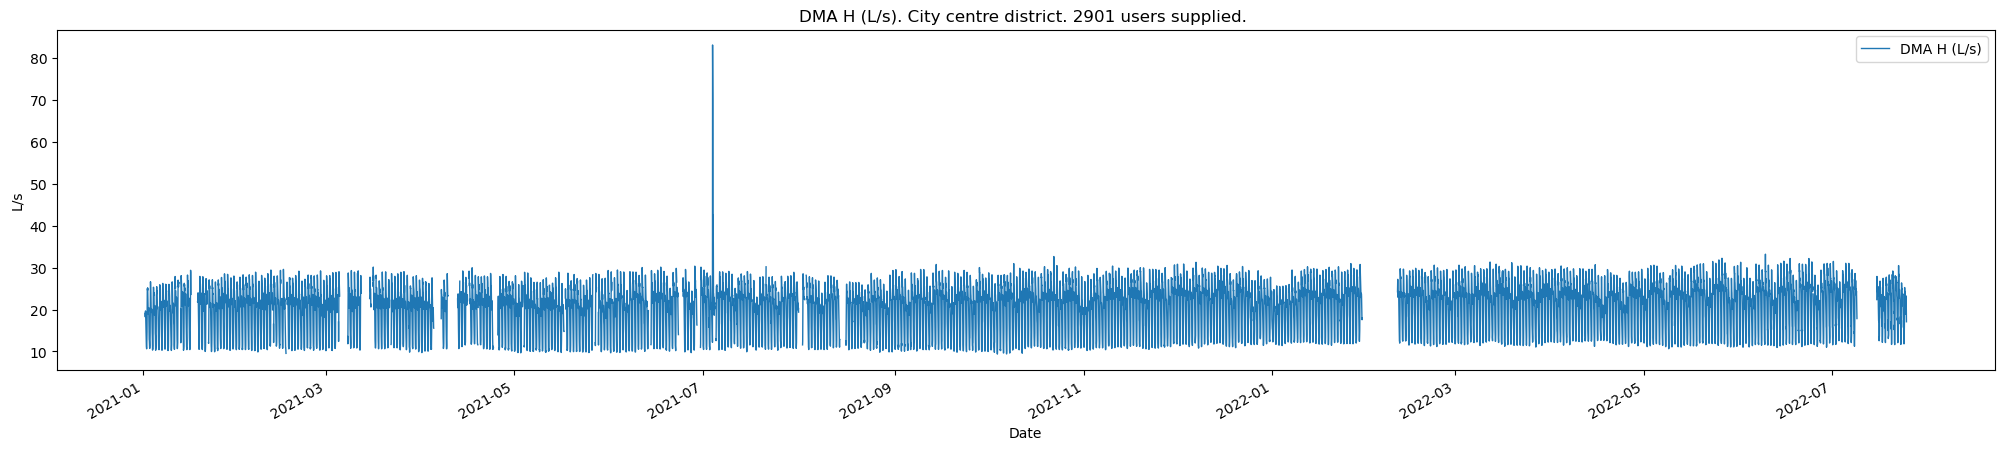

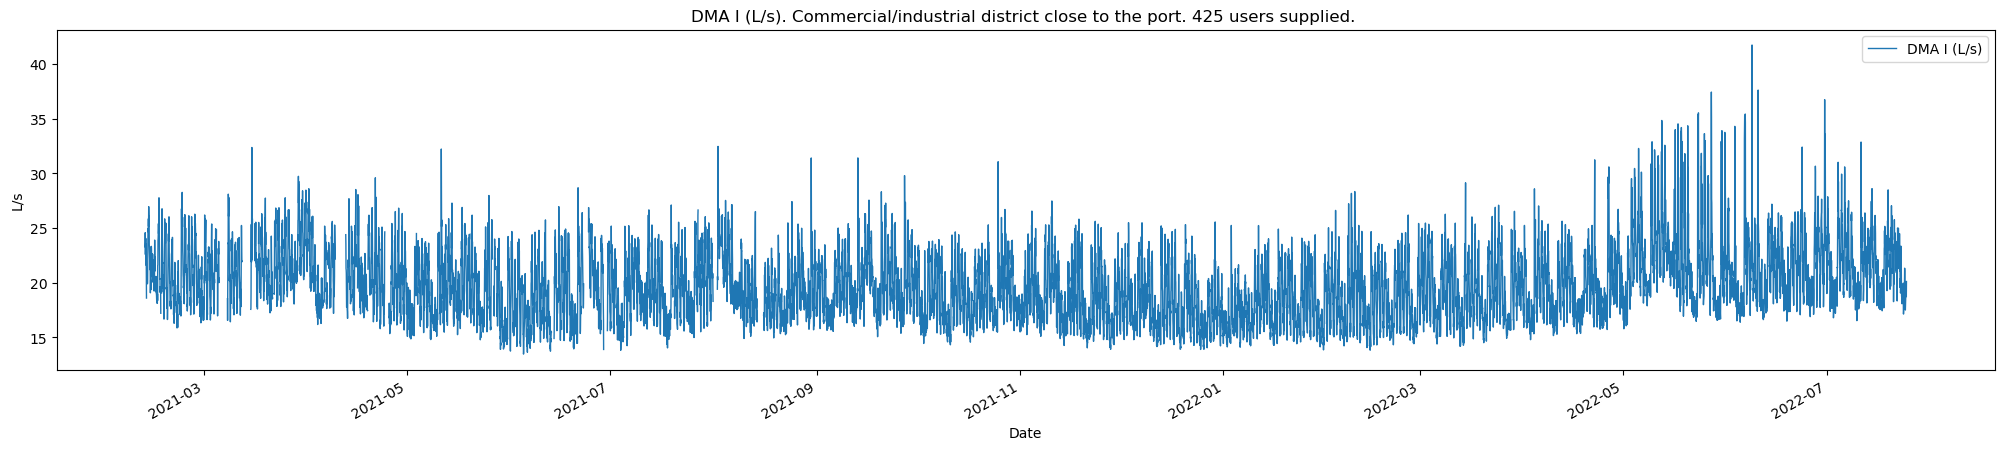

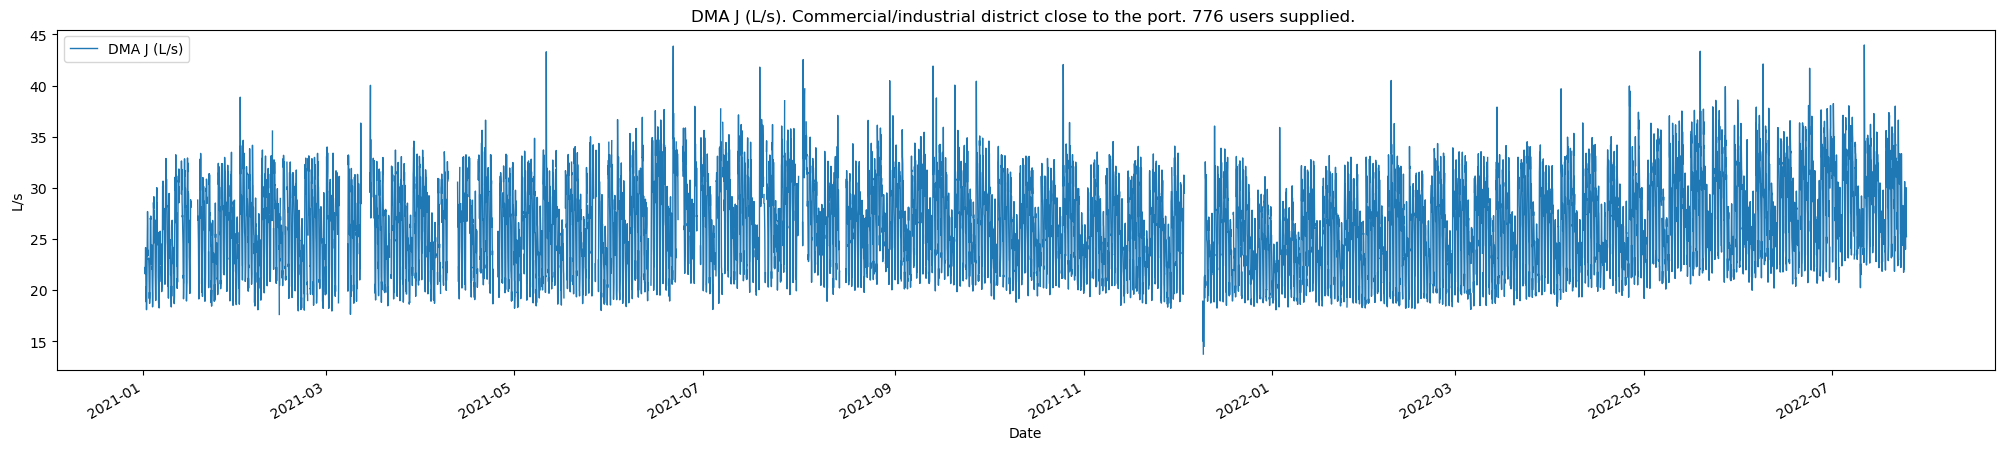

In [56]:
# plot/visualize time series for the whole monitoring period
for i in range(10):
    fig, ax = plt.subplots()
    inflow_data.plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1)
    plt.title(dma_list[i] + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. ")
    plt.xlabel("Date")
    plt.ylabel("L/s")
    plt.show()

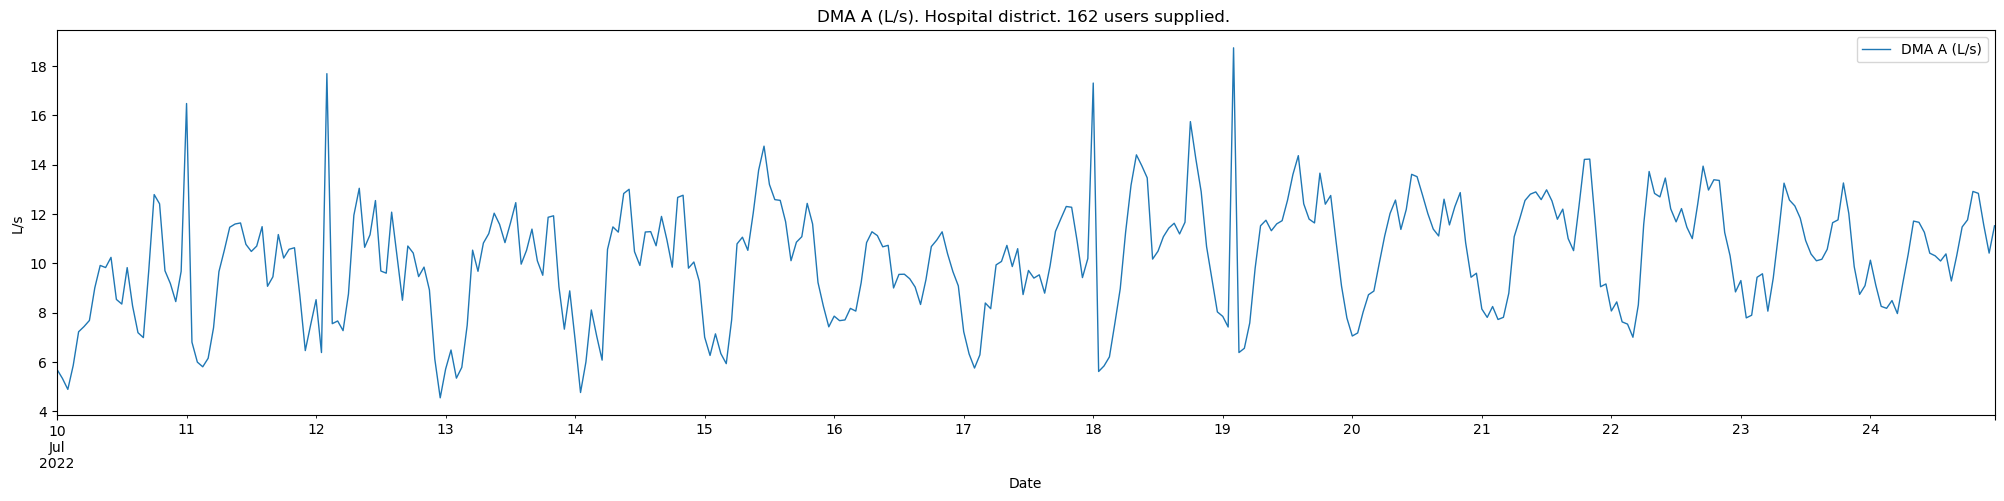

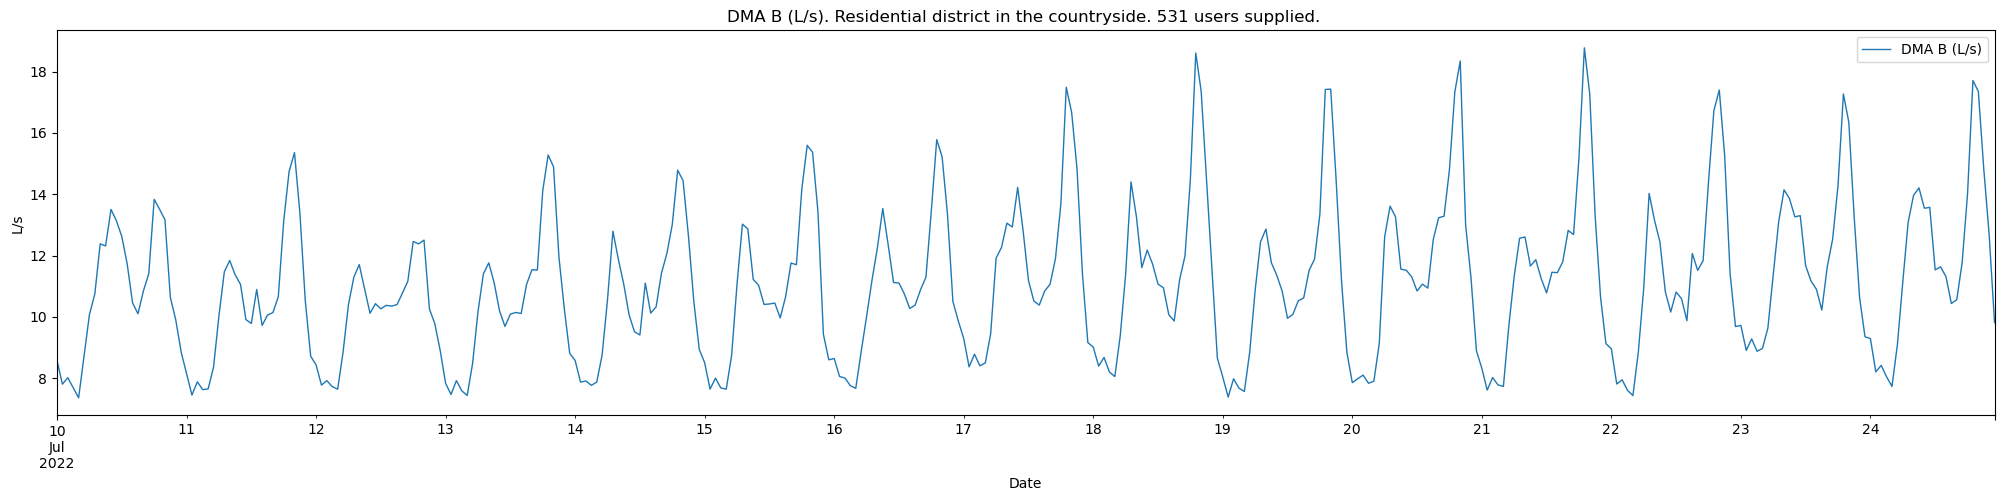

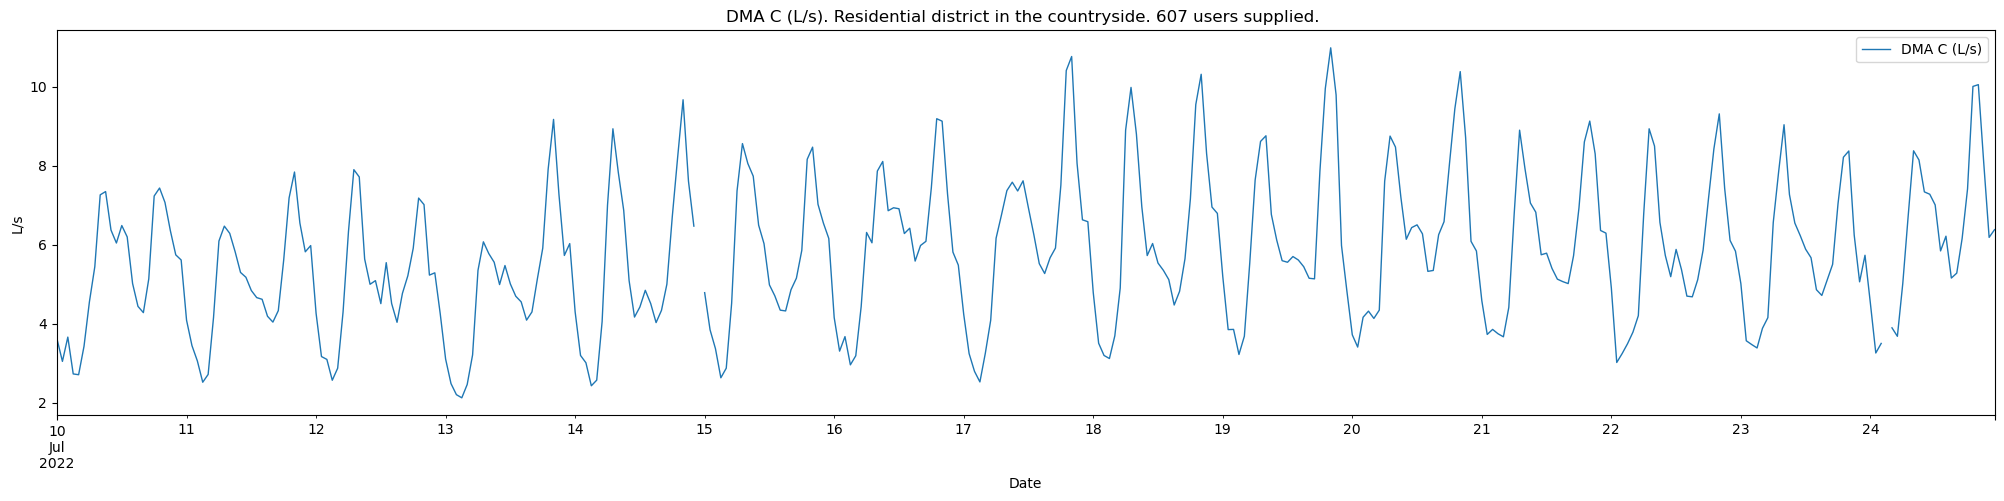

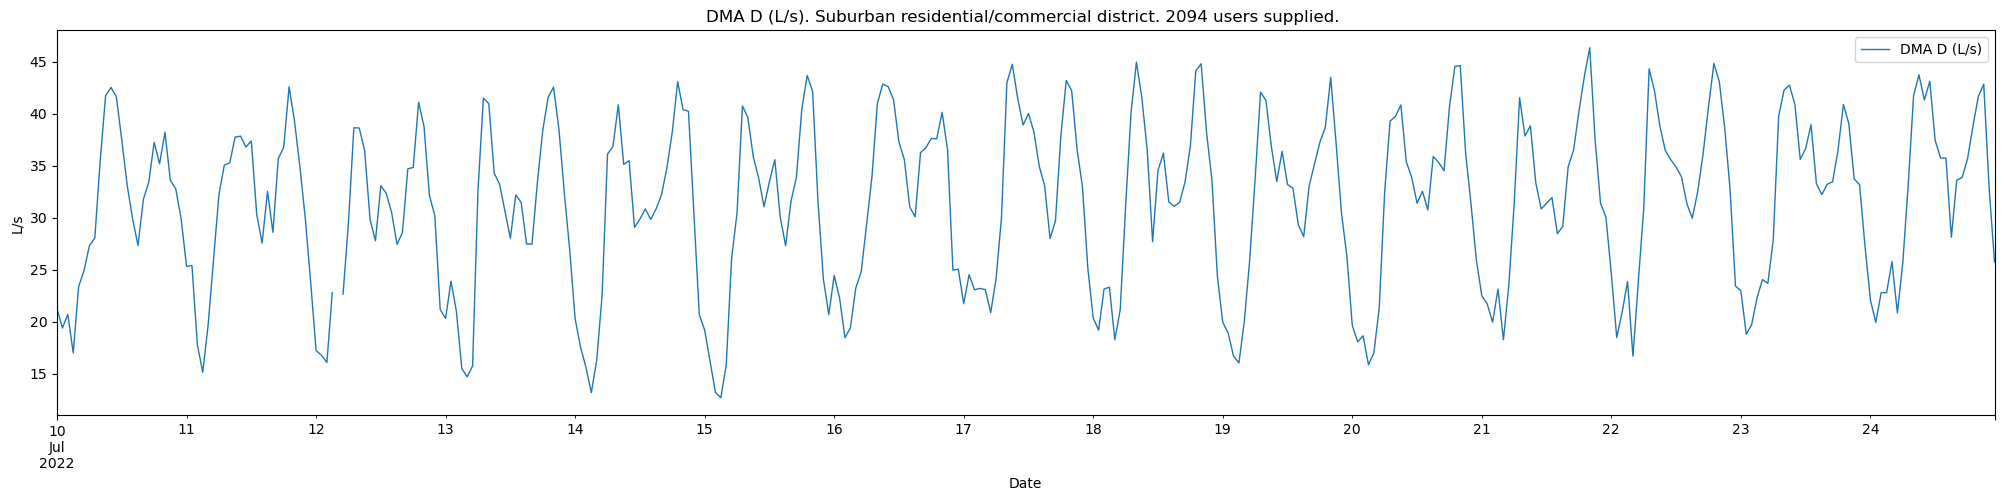

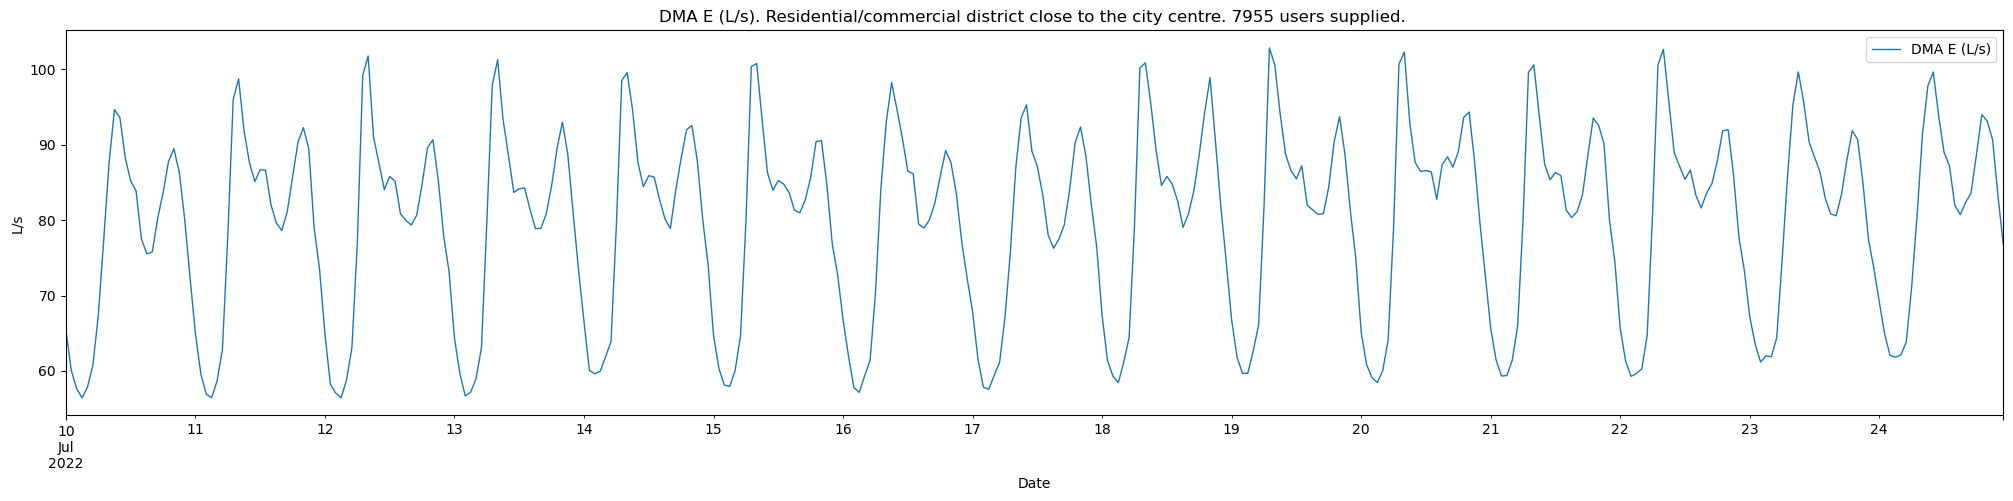

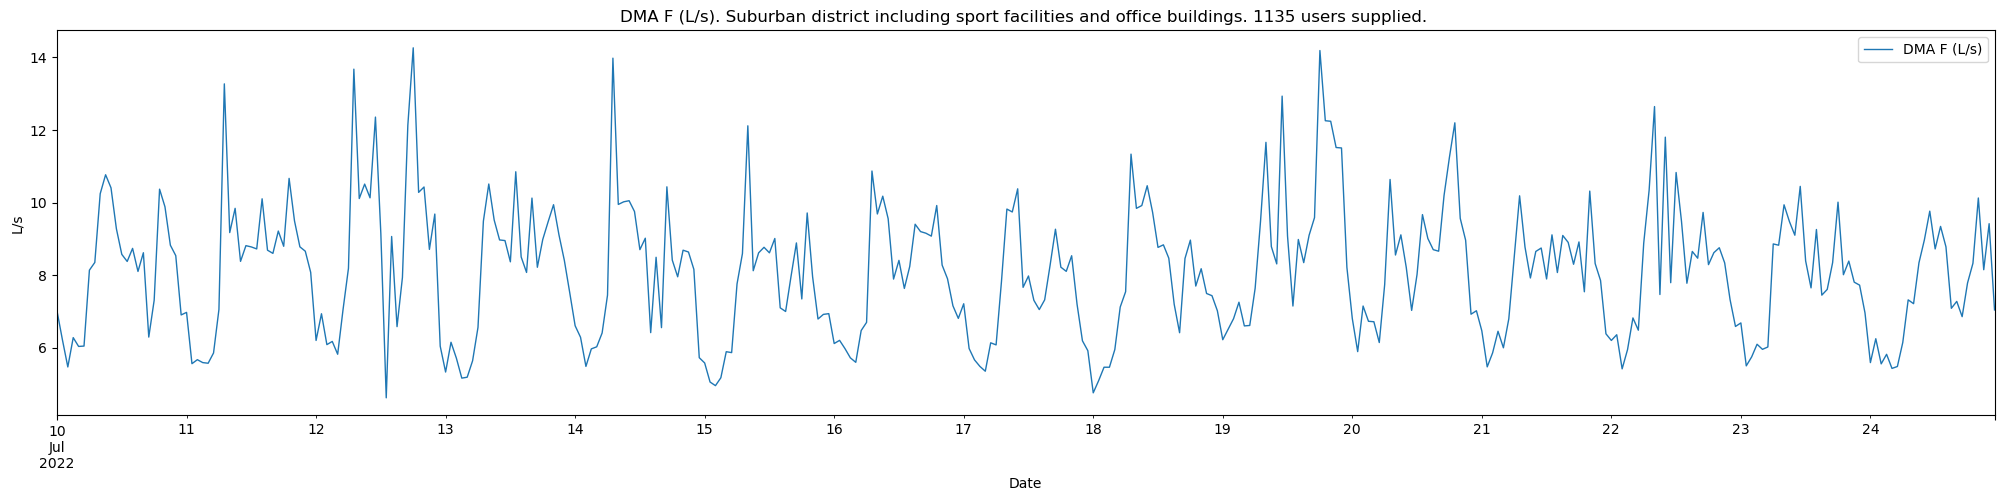

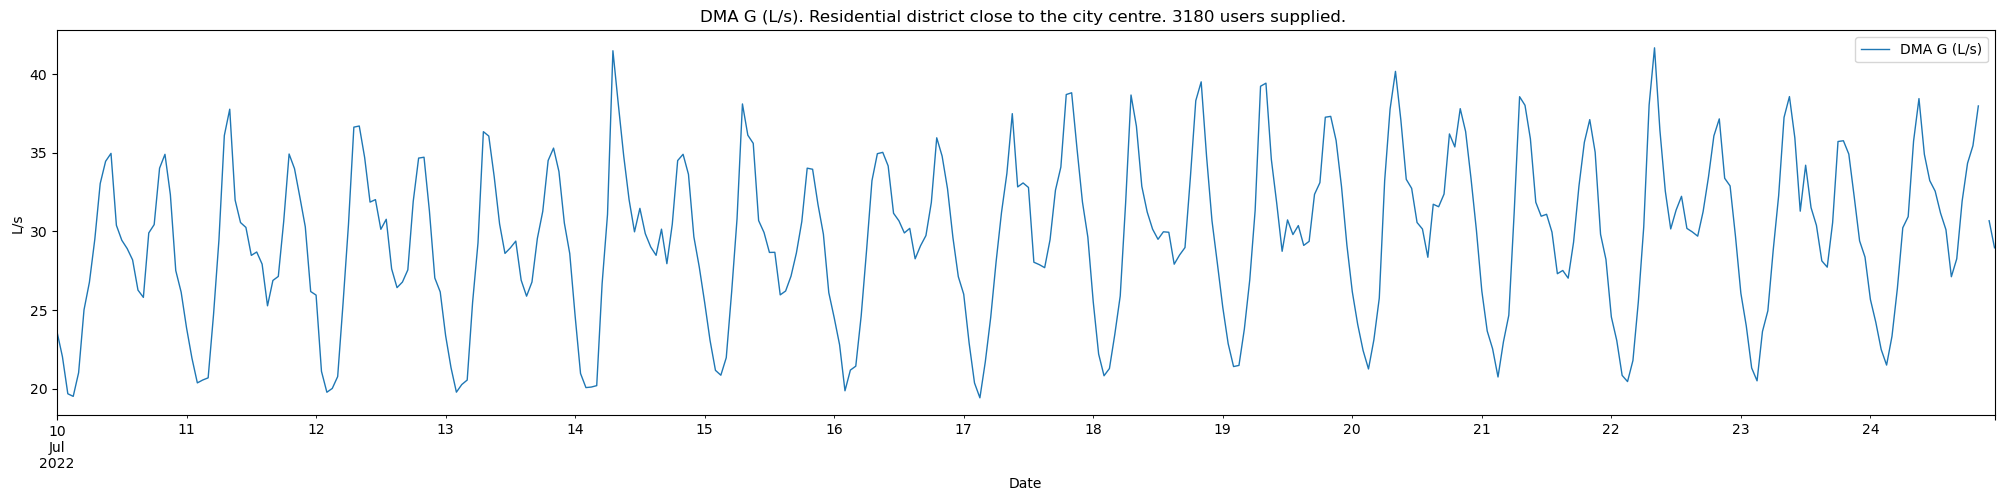

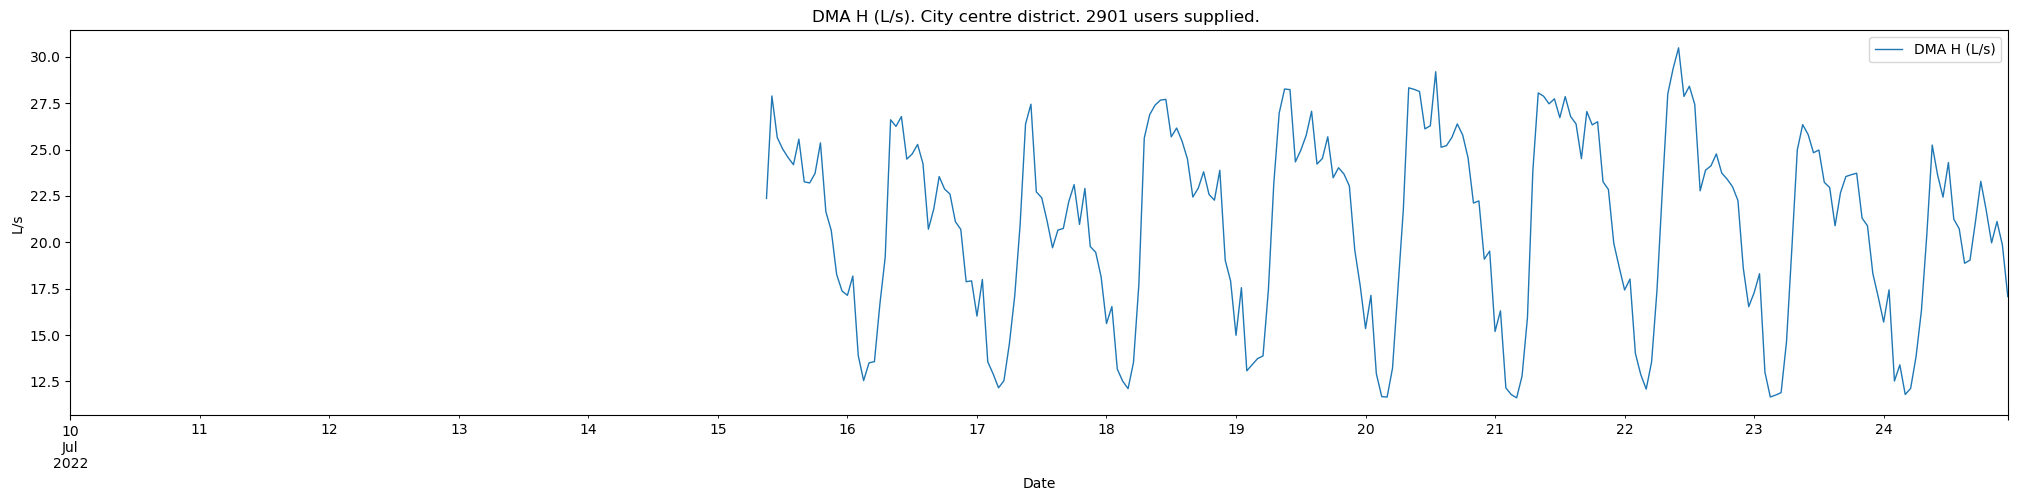

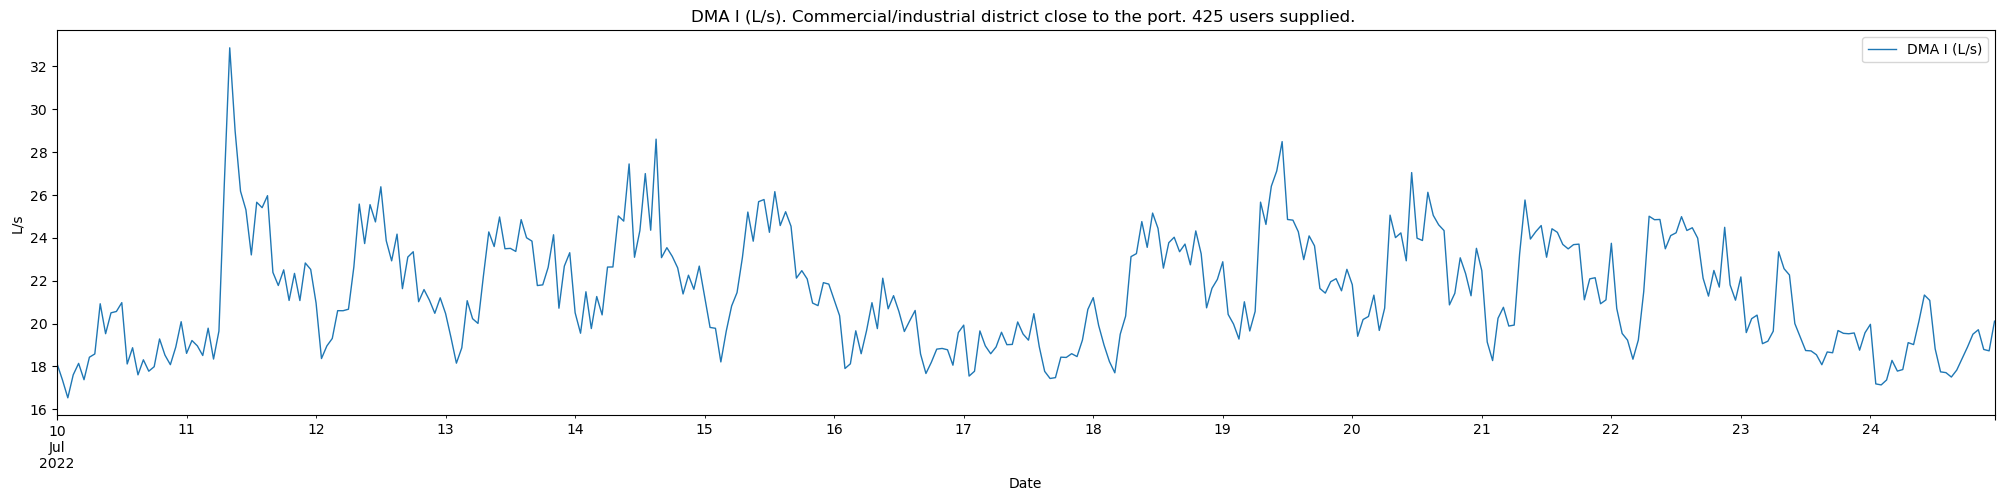

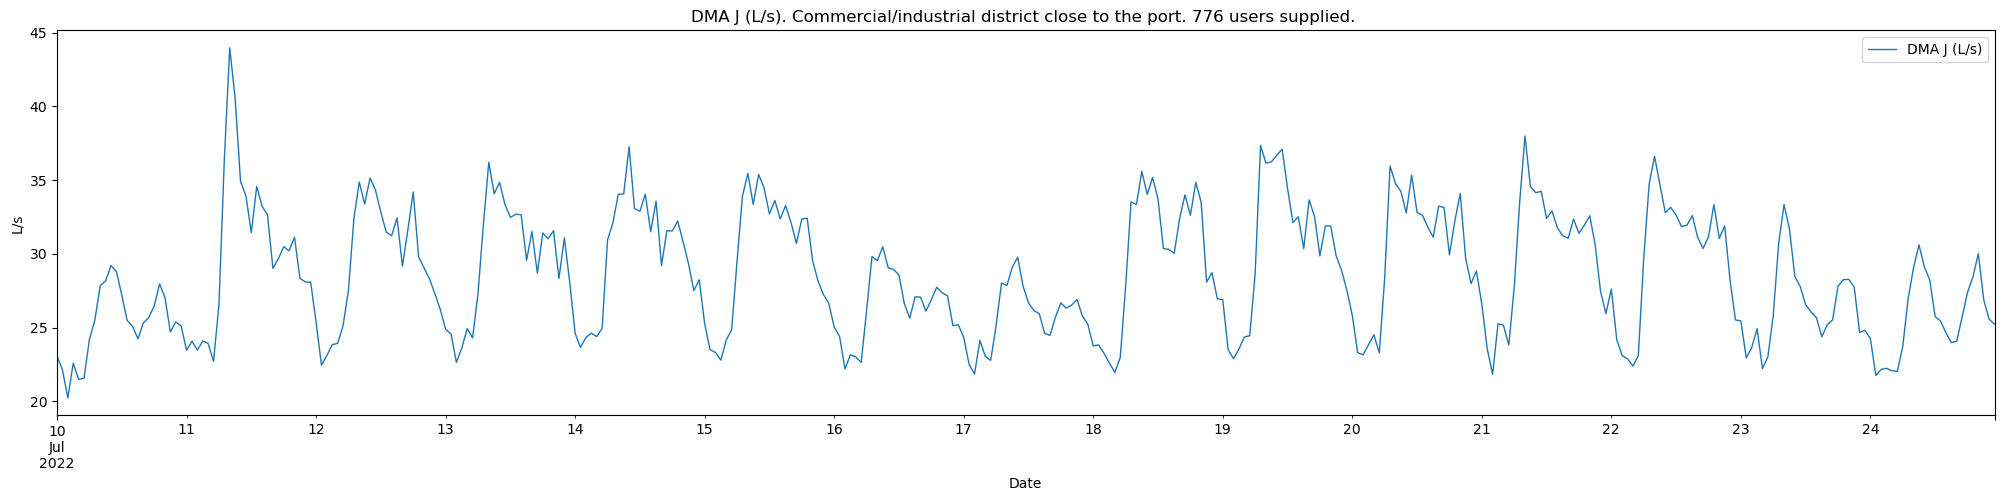

In [57]:
# define start and end dates for analysis
start = '2022-07-10'
end = '2022-07-24'

# plot time series for start and end dates
for i in range(10):
    fig, ax = plt.subplots()
    inflow_data[start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1)
    plt.title(dma_list[i] + ". " + dma_descripton[i] +". "+ str(users_supplied[i]) + " users supplied. ")
    plt.xlabel("Date")
    plt.ylabel("L/s")
    plt.show()

DATA PREPROCESING

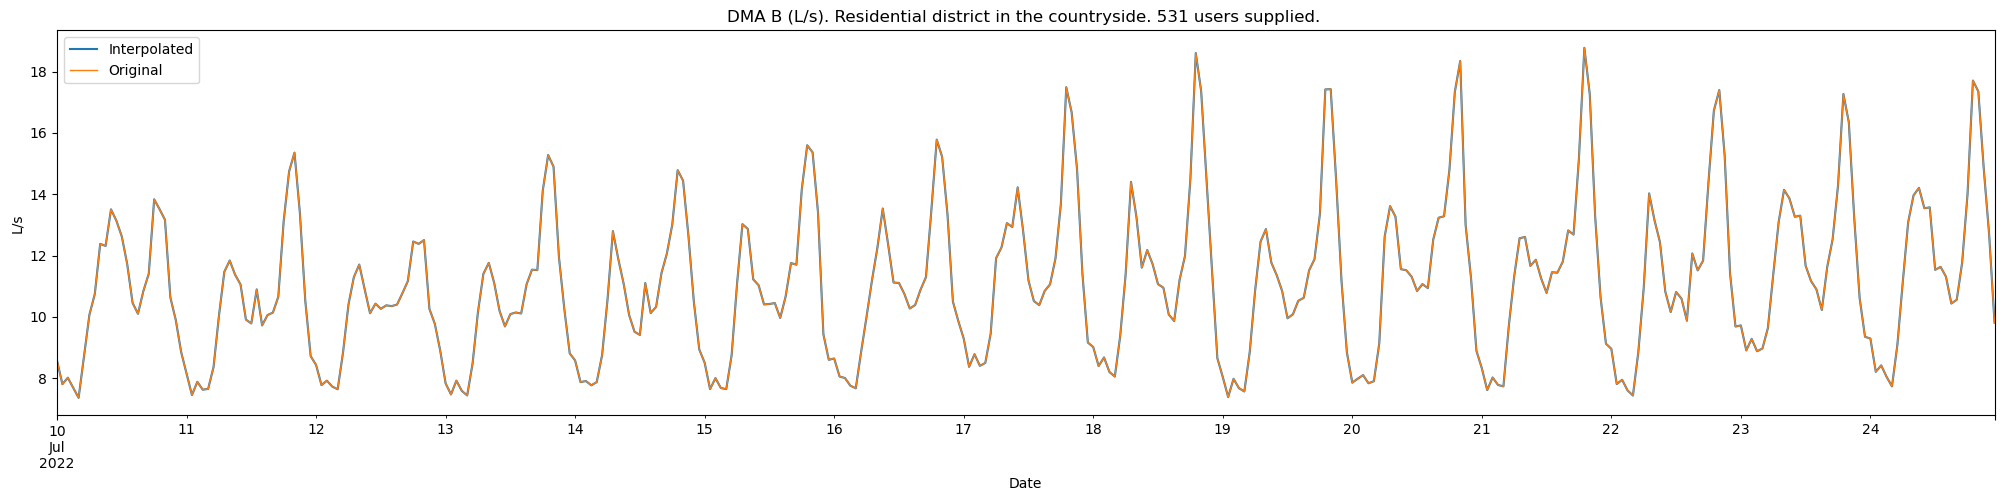

In [58]:
# select dma for analysis
dma = 'DMA B (L/s)'

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# copy data from dataframe in a new time series dataframe
tseries_df = inflow_data[dma][start:end].copy()

# fill missing values with interpolation technique
tseries_df.interpolate(limit_direction='both',inplace=True)

# plot original and interpolated time series for selected dma
fig, ax = plt.subplots()
tseries_df.plot(label='Interpolated')
inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
plt.xlabel("Date")
plt.ylabel("L/s")
plt.legend()
plt.show()

TBATS MODEL

In [59]:
# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.tbats import TBATS

In [60]:
tseries_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 360 entries, 2022-07-10 00:00:00 to 2022-07-24 23:00:00
Series name: DMA B (L/s)
Non-Null Count  Dtype  
--------------  -----  
360 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


In [61]:
# Check if data is stationary (if the data is steady over time ( -- ), i.e. does not have grow ( / ) or decline  ( \ ) patterns)

result = adfuller(tseries_df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.308554
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


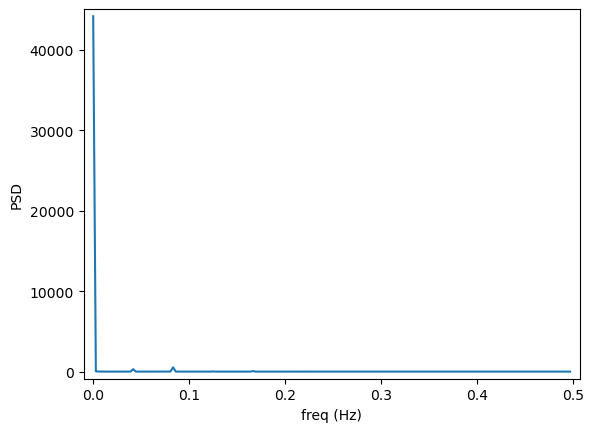

In [62]:
# Determine frequencies
f = np.fft.fftfreq(len(tseries_df))

# Compute power spectral density
psd = np.abs(np.fft.fft(tseries_df))**2 / len(tseries_df)

# Make plot
plt.plot(f[f>=0], psd[f>=0])
plt.xlabel('freq (Hz)')
plt.ylabel('PSD')
plt.margins(0.02)

In [63]:
d = {'frequency': f[f>=0], 'psd': psd[f>=0]}
top = pd.DataFrame(d).sort_values(by='psd',ascending=False).head(6)
1 /  round(top.frequency,2)

0           inf
30    12.500000
15    25.000000
60     5.882353
1           inf
45     8.333333
Name: frequency, dtype: float64

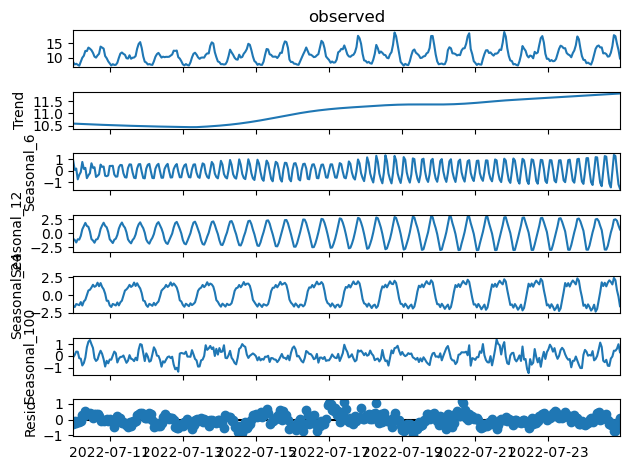

In [64]:
# Apply Multiple Seasonal Trend Decomposition

mstl = MSTL(tseries_df, periods=[6,12,24,100], iterate = 3)
res = mstl.fit()

res.plot(resid = True)
plt.show()

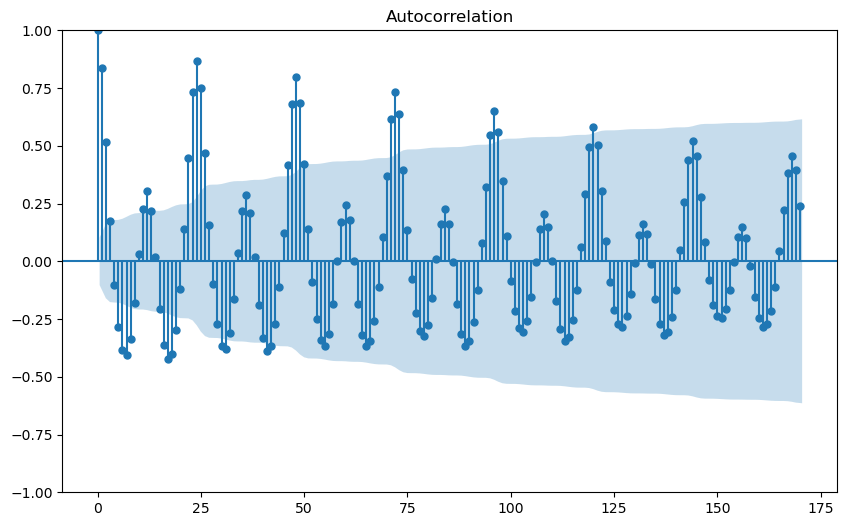

In [65]:
fig, ax = plt.subplots(figsize = (10, 6))

plot_acf(tseries_df, lags = 170, ax = ax)
plt.show()

In [66]:
# create an utility metric function
def print_metrics(y_true, y_pred, model_name):
    mae_ = mean_absolute_error(y_true, y_pred)
    rmse_ = mean_squared_error(y_true, y_pred, square_root = True)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    smape_ = mean_absolute_percentage_error(y_true, y_pred, symmetric = True)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_ }
    
    df = pd.DataFrame(dict_, index = [model_name])
    return(df.round(decimals = 2))

def print_performance_indicators(y_obs,y_pred):
    PI_1 = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    PI_2 = np.max(np.abs(y_obs - y_pred))

    PI_3 = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    print('Performance indicators')

    print(f"P1      P2      P3")
    print(f"{PI_1:{1}.{3}}  {PI_2:{1}.{3}}  {PI_3:{1}.{3}}  \n")

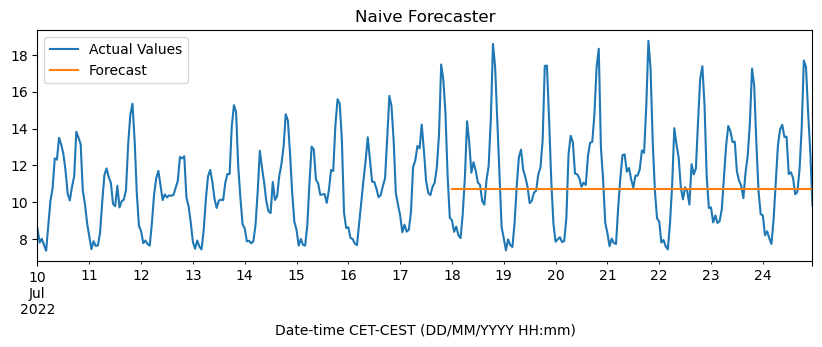

MAE  RMSE  MAPE  SMAPE
Naive Forecaster  2.17  2.81  0.18   0.19

In [67]:
# create a baseline forecasting model

y = tseries_df
y_train, y_test = temporal_train_test_split(y, test_size = 168)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy = 'mean')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize = (10,3))
tseries_df.plot(title = 'Naive Forecaster', ax = ax)
y_pred.plot(ax = ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print_metrics(y_test, y_pred, 'Naive Forecaster')

In [68]:
print_performance_indicators(y_test,y_pred)

Performance indicators
P1      P2      P3
2.15  8.07  2.17  



In [69]:
# create TBATS forecasting model

# forecaster = TBATS(sp = [6,12,24], n_jobs = 12)
# forecaster.fit(y_train)
# y_pred = forecaster.predict(fh)

# fig, ax = plt.subplots(figsize = (10,3))  
# tseries_df.plot(title = 'TBATS Forecaster', xlabel = '', ax = ax)
# y_pred.plot(ax = ax)
# ax.legend(['Actual Values', 'Forecast'])
# plt.show()

# print_metrics(y_test, y_pred, 'TBATS Forecaster')

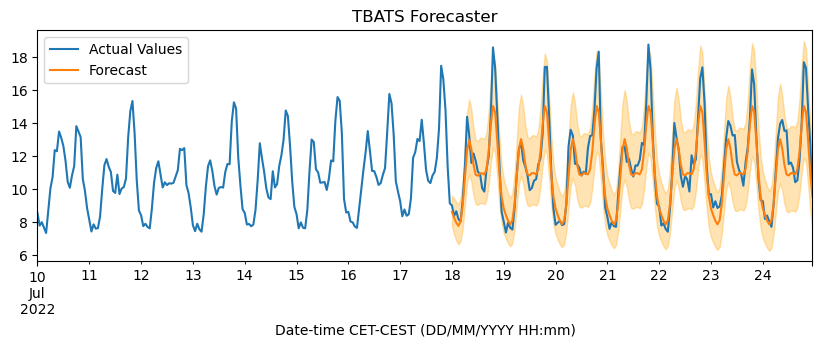

Performance indicators
P1      P2      P3
0.82  3.72  0.777  



In [71]:
forecaster = TBATS(sp = [6,12,24], n_jobs = 12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

y_pred_interval = forecaster.predict_interval(fh,coverage=0.95)

fig, ax = plt.subplots(figsize = (10,3))
tseries_df.plot(title = 'TBATS Forecaster', xlabel = '', ax = ax)
y_pred.plot(ax = ax)
ax.fill_between(y_pred.index, y_pred_interval['DMA B (L/s)'][0.95]['lower'], y_pred_interval['DMA B (L/s)'][0.95]['upper'],color='orange', alpha=0.3)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print_performance_indicators(y_test, y_pred)